<h1 style="text-align:center;">Previsão da Produção de Gás Natural em Poços ANP

<img src="Anp-logo-3.png" width="500" height="500"/>

# <a id='sumario'></a>Sumário
1. [**Entendimento do problema**](#entendimento-do-problema)
2. [**Bibliotecas**](#bibliotecas)
<br>
3. [**Entendimento dos Dados**](#entendimento-dos-dados)       
- 3.1 [Carregando os Dados](#carregando-os-dados)
- 3.2 [Primeiras impressões dos dados](#primeiras-impressoes-dos-dados)
- 3.3 [Primeiras transformações nos dados](#primeiras-transformacoes-nos-dados)
4. [**Descritiva e Transformações dos Dados**](#descritiva-e-transformacoes-dos-dados)
- 4.1 [Univariadas](#univariadas)
- 4.2 [Bivariada e transformações nas categóricas](#bivariada-e-transformacoes-nas-categoricas)
    - 4.2.1 [Categóricas com poucos valores únicos](#categoricas-com-poucos-valores-unicos)
    - 4.2.2 [Categóricas com muitos valores únicos](#categoricas-com-muitos-valores-unicos)
      - 4.2.2.1 ['Operador'](#operador)
      - 4.2.2.2 ['Corrente'](#corrente)
- 4.3 [Bivariada e transformações nas contínuas](#bivariada-e-transformacoes-nas-continuas)
     - 4.3.1 [Outliers iniciais](#outliers-iniciais)
     - 4.3.2 [Matriz de Correlação](#matriz-de-correlacao)
     - 4.3.3 [Distribuição e Normalidade](#distribuicao-e-normalidade)
     - 4.3.4 [Bivariada e Linearidade](#bivariada-e-linearidade)
     - 4.3.5 [Transformações](#transformacoes)
     - 4.3.6 [VIF (Fator de Inflação da Variância)](#vif-fator-de-inflacao-da-variancia)
5. [**Planejamento do modelo**](#planejamento-do-modelo)
- 5.1 [Comparando modelos com o Pycaret](#comparando-modelos-com-o-pycaret)
     - 5.1.1 [Avaliando na base de testes](#avaliando-na-base-de-testes)
6. [**Regressão no Stats Models**](#regressao-no-stats-models)
- 6.1 [Summary](#summary)
- 6.2 [Avaliação do modelo e resíduos](#avaliacao-do-modelo-e-residuos)
<br>
7. [**Regressão ScikitLearn**](#regressao-scikitlearn)<br>
<br>
8. [**Modelo Final**](#modelo-final)
- 8.1 [Setup](#setup)
- 8.2 [Validação Cruzada do modelo](#validacao-cruzada-do-modelo)
- 8.3 [Avaliação do modelo](#avaliacao-do-modelo)
- 8.4 [Data Frames com as previsões](#data-frames-com-as-previsoes)
     - 8.4.1 [Treino](#treino)
     - 8.4.2 [Teste](#teste)
- 8.5 [Salvando o modelo e pipeline](#salvando-o-modelo-e-pipeline)
9. [**Relatório Gerencial**](#relatorio-gerencial)
- 9.1 [Interferência das variáveis explicativas na produção de gás](#interferencia-das-variaveis-explicativas-na-producao-de-gas)
     - 9.1.1 [Contínuas](#continuas)
     - 9.1.2 [Dummies](#dummies)

<a id='entendimento-do-problema'></a>
# 1. Entendimento do problema

O projeto de ciência de dados em questão visa prever a **quantidade média diária de produção de gás natural** para poços existentes e recém-criados, onde a produção de gás ainda não é conhecida. Os dados para este projeto são extraídos do portal .gov do governo federal, disponibilizados pela **Agência Nacional do Petróleo (ANP)** https://dados.gov.br/dados/conjuntos-dados/producao-de-petroleo-e-gas-natural-por-poco.

A **extração de gás natural** envolve uma série de etapas complexas. Apesar das vantagens, a produção de gás natural enfrenta uma série de desafios. A exploração e produção podem ter impactos ambientais significativos, incluindo a liberação de gases de efeito estufa e a potencial contaminação das águas subterrâneas.

No Brasil, poucos poços produzem gás natural. Com poucos gasodutos para escoar a produção, o país reinjetou em janeiro 49,8% do produto extraído das jazidas. A maior parte da produção continua na Bacia de Santos, responsável por 68,1% do gás brasileiro.

A **reinserção do gás natural** nos poços é uma estratégia industrial comum. Como a produção brasileira da commodity frequentemente é associada à extração de petróleo, o produto é reinserido pelas petroleiras nos campos para aumentar a pressão e, assim, conseguir extrair mais óleo dos poços.

Ter uma **previsão precisa dos valores produzidos** pode contribuir significativamente para todos os processos de produção. Isso pode ajudar na tomada de decisões estratégicas, otimização dos processos e na redução dos custos operacionais.

A produção de gás natural é influenciada por várias variáveis. Estas incluem fatores geológicos, técnicas de exploração utilizadas, condições climáticas, políticas governamentais, entre outros. A **compreensão e interpretabilidade de cada uma dessas variáveis** e sua relação com a quantidade média produzida por dia é crucial para tomadas de decisão como a implementação de novos poços, metas, troca de operadores entre outras, devem ser prioridade na modelagem.

A variável resposta "**Gás Natural (Mm³/dia)**" refere-se à quantidade média diária de gás natural produzida em milhões de metros cúbicos (Mm³). O metro cúbico é uma unidade padrão no Sistema Internacional de Unidades para volume.

<a id='bibliotecas'></a>
# 2. Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import calendar
import plotly.graph_objects as go
import statsmodels.api as sm
import itertools

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from scipy.stats import zscore
from scipy.stats import kruskal
from scipy import stats
from ydata_profiling import ProfileReport
from pycaret.regression import *
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from math import sqrt
from tqdm import tqdm


%matplotlib inline

<a id='entendimento-dos-dados'></a>
# 3. Entendimento dos Dados

Os dados utilizados neste projeto são provenientes dos **poços de produção de petróleo** sob a regulamentação da **Agência Nacional do Petróleo (ANP)**. Esses poços estão localizados em diferentes ambientes, incluindo **Terra, Mar e Pré-sal**. Os dados foram coletados durante o **primeiro semestre de 2023**.

Os dados contêm uma variedade de variáveis relacionadas à **extração de commodities**, como **óleo e gás natural**. Além disso, eles incluem informações **geográficas e químicas** que podem ser úteis para entender os fatores que influenciam a **produção de petróleo e gás natural**.

Um **dicionário completo dos dados** está disponível https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/arquivos-producao-de-petroleo-e-gas-natural-por-poco/metadados-dados-producao-poco.pdf, que fornece uma descrição detalhada de todas as variáveis nos dados. Além disso, um **resumo das principais variáveis e suas explicações** é fornecido abaixo.

<a id='carregando-os-dados'></a>
## 3.1 Carregando os Dados

Para lidar com a estrutura desorganizada dos dados originais, que são separados por mês e por local de extração (**Mar**, **Terra** e **Pré-sal**), foi elaborada uma função específica. Esta função tem o objetivo de unificar todos os arquivos .csv em um único conjunto de dados.

A função realiza várias transformações nos dados. Primeiro, ela lê os arquivos .csv do caminho especificado. Em seguida, faz algumas correções em strings para garantir a consistência dos dados. Além disso, a função adiciona uma coluna para definir o **local da extração**, que pode ser Mar, Terra ou Pré-sal.

Após realizar todas essas transformações, a função salva um novo arquivo na mesma pasta do notebook com todos os dados unificados e transformados. Isso facilita a análise subsequente dos dados, pois agora todos os dados estão em um formato consistente e fácil de usar.

In [2]:
def carregar_arquivos(pasta, arquivo_salvo='df_todos.csv'):
    # Verifica se o arquivo já existe
    if os.path.exists(arquivo_salvo):
        # Se o arquivo existir, carrega o arquivo
        df_todos = pd.read_csv(arquivo_salvo)
    else:
        # Se o arquivo não existir, processa os arquivos .csv
        # Ordena os arquivos no diretório
        arquivos = sorted(os.listdir(pasta))
        # Cria uma lista vazia para armazenar todos os DataFrames
        todos_arquivos = []
        # Itera sobre cada arquivo no diretório
        for arquivo in arquivos:
            # Verifica se o arquivo é um arquivo .csv
            if arquivo.endswith('.csv'):
                # Extrai o tipo de local de extração do nome do arquivo
                local = arquivo.split('_')[-1].replace('.csv', '')
                # Extrai o mês do nome do arquivo
                mes = int(arquivo.split('_')[1])
                # Lê o arquivo .csv, ignorando a primeira linha (cabeçalho)
                df = pd.read_csv(os.path.join(pasta, arquivo), sep=';', header=None, skiprows=3)
                # Obtém o número de colunas no DataFrame
                num_cols = df.shape[1]
                # Determina o número de colunas a serem usadas (22 ou o número total de colunas, o que for menor)
                cols_to_use = min(22, num_cols)
                # Seleciona as colunas a serem usadas
                df = df.iloc[:, :cols_to_use]
                # Substitui pontos por nada e vírgulas por pontos em todas as células do DataFrame
                df = df.applymap(lambda x: str(x).replace('.', '').replace(',', '.') if isinstance(x, str) else x)
                # Adiciona uma coluna 'Local' ao DataFrame com o tipo de local de extração
                df['Local'] = local
                # Adiciona o DataFrame à lista de todos os arquivos
                todos_arquivos.append(df)
        # Concatena todos os DataFrames na lista em um único DataFrame
        df_todos = pd.concat(todos_arquivos, ignore_index=True)
        # Define os nomes das colunas do DataFrame final
        colunas = ['Estado', 'Bacia', 'Nome Poço ANP', 'Nome Poço Operador', 'Campo', 'Operador',
                   'Número do Contrato', 'Período', 'Óleo (bbl/dia)', 'Condensado (bbl/dia)', 
                   'Petróleo (bbl/dia)', 'Gás Natural (Mm³/dia)', 'Gás Natural (Mm³/dia) N Assoc',
                   'Gás Natural (Mm³/dia) Total', 'Volume Gás Royalties (m³/mês)', 'Água (bbl/dia)',
                   'Instalação Destino', 'Tipo Instalação', 'Tempo de Produção (hs por mês)',
                   'Período da Carga', 'Corrente', 'Grau API', 'Local']  # Adiciona 'Local' à lista de colunas
        df_todos.columns = colunas
        # Define os tipos de dados das colunas do DataFrame final
        tipos = {'Estado': object, 'Bacia': object, 'Nome Poço ANP': object, 
                 'Nome Poço Operador': object, 'Campo': object, 
                 'Operador': object, 'Número do Contrato': object, 
                 'Período': object, 'Óleo (bbl/dia)': float, 
                 'Condensado (bbl/dia)': float, 'Petróleo (bbl/dia)': float,
                 'Gás Natural (Mm³/dia)': float, 
                 'Gás Natural (Mm³/dia) N Assoc': object,
                 'Gás Natural (Mm³/dia) Total': object,
                 'Volume Gás Royalties (m³/mês)': object,
                 'Água (bbl/dia)': float,
                 'Instalação Destino': object,
                 'Tipo Instalação': object,
                 'Tempo de Produção (hs por mês)': int,
                 'Período da Carga': object,
                 'Corrente': object,
                 'Grau API': float,
                 'Local': object}  # Adiciona o tipo de dado para a coluna "Local"
        # Converte as colunas para os tipos de dados especificados
        for coluna, tipo in tipos.items():
            df_todos[coluna] = df_todos[coluna].astype(tipo)
        
        # Salva o DataFrame processado como um arquivo .csv
        df_todos.to_csv(arquivo_salvo,encoding='utf-8', index=False)

    return df_todos

df = carregar_arquivos('bases')

<a id='primeiras-impressoes-dos-dados'></a>
## 3.2 Primeiras imprensões dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40035 entries, 0 to 40034
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Estado                          40035 non-null  object 
 1   Bacia                           40035 non-null  object 
 2   Nome Poço ANP                   40035 non-null  object 
 3   Nome Poço Operador              40035 non-null  object 
 4   Campo                           40035 non-null  object 
 5   Operador                        40035 non-null  object 
 6   Número do Contrato              40035 non-null  object 
 7   Período                         40035 non-null  object 
 8   Óleo (bbl/dia)                  40035 non-null  float64
 9   Condensado (bbl/dia)            40035 non-null  float64
 10  Petróleo (bbl/dia)              40035 non-null  float64
 11  Gás Natural (Mm³/dia)           40035 non-null  float64
 12  Gás Natural (Mm³/dia) N Assoc   

In [4]:
# # Cria um relatório de perfil de dados para df_train
# profile = ProfileReport(df)

# # Gera o relatório no próprio Jupyter Notebook
# profile.to_notebook_iframe()

<a id='primeiras-transformacoes-nos-dados'></a>
## 3.3 Primeiras transformações nos dados

Pequenos preenchimentos de Nans e correções de valores strings, usando a lógica e conhecimentos geográficos

In [5]:
# Crie um mapa dos valores de 'Nome Poço ANP' para 'Corrente' e 'Grau API'
mapa_corrente = df.dropna(subset=['Corrente']).set_index('Nome Poço ANP')['Corrente'].to_dict()
mapa_grau_api = df.dropna(subset=['Grau API']).set_index('Nome Poço ANP')['Grau API'].to_dict()

# Preencha os valores faltantes nas colunas 'Corrente' e 'Grau API' com os valores correspondentes do mapa
df['Corrente'] = df['Corrente'].fillna(df['Nome Poço ANP'].map(mapa_corrente))
df['Grau API'] = df['Grau API'].fillna(df['Nome Poço ANP'].map(mapa_grau_api))

# Exclua as linhas que ainda têm valores NaN
df = df.dropna()

In [6]:
# Corrigindo nome dos estados
df['Estado'] = df['Estado'].replace({
    'EspÃ­rito Santo': 'Espírito Santo',
    'CearÃ¡': 'Ceará',
    'SÃ£o Paulo': 'São Paulo',
    'MaranhÃ£o': 'Maranhão'
})

 - Colunas relacionadas a um poço específico não nos ajuda a generalizar o modelo, assim como variáveis de datas, ou que são repetitivas ou redundantes. Assim também como algumas como a relacionada a Condensado, que tem muito poucos dados. 

In [7]:
# Retirando colunas que não tem haver com a produção, redundantes ou não significativas.
cols_to_drop = ['Nome Poço Operador','Nome Poço ANP','Número do Contrato', 'Período','Condensado (bbl/dia)',
                'Gás Natural (Mm³/dia) N Assoc', 'Gás Natural (Mm³/dia) Total', 'Volume Gás Royalties (m³/mês)',
                'Instalação Destino', 'Tipo Instalação', 'Período da Carga','Óleo (bbl/dia)','Campo']
df = df.drop(columns=cols_to_drop)

df = df[~((df[['Tempo de Produção (hs por mês)', 'Petróleo (bbl/dia)', 'Água (bbl/dia)']] < 1).any(axis=1) |
           (df['Gás Natural (Mm³/dia)'] <= 0))]

<a id='descritiva-e-transformacoes-dos-dados'></a>
# 4. Descritiva e Transformações dos Dados

<a id='univariadas'></a>
## 4.1 Univariadas

In [8]:
def describe_continuous(df):
    # Alterar a formatação global de exibição de float
    pd.options.display.float_format = '{:.2f}'.format

    # Selecionar variáveis contínuas
    continuous_vars = df.select_dtypes(include=['int64','int32','float64'])

    # Obter estatísticas descritivas
    desc = continuous_vars.describe()

    # Adicionar uma linha para a quantidade de valores únicos
    unique_counts = pd.DataFrame(continuous_vars.nunique(), columns=['unique']).transpose()
    desc = pd.concat([desc, unique_counts])

    return desc

In [9]:
def describe_categorical(df):
    categorical_vars = df.select_dtypes(include=['object', 'bool'])
    return categorical_vars.describe()

In [10]:
# Estatisticas variáveis numéricas
describe_continuous(df)

Petróleo (bbl/dia)  Gás Natural (Mm³/dia)  Água (bbl/dia)  \
count             25280.00               25280.00        25280.00   
mean               1081.56                  44.66          641.61   
std                4133.01                 196.48         1844.77   
min                   1.00                   0.00            1.00   
25%                   3.43                   0.00           44.71   
50%                   8.20                   0.01          193.31   
75%                  30.93                   0.34          489.89   
max               48436.65                3233.59        27178.83   
unique            21918.00                6642.00        23691.00   

        Tempo de Produção (hs por mês)  Grau API  
count                         25280.00  25280.00  
mean                            636.79     24.99  
std                             158.01      5.98  
min                               1.00     13.20  
25%                             634.00     23.20  
50%                             705.00     23.20  
75%                             732.00     24.70  
max                             744.00     54.80  
unique                          728.00     57.00

In [11]:
# Estatisticas variáveis Categóricas
describe_categorical(df)

Estado     Bacia   Operador     Corrente  Local
count                 25280     25280      25280        25280  25280
unique                    9         8         35           64      3
top     Rio Grande do Norte  Potiguar  Petrobras  RGN Mistura  Terra
freq                  12701     13578      13462        12149  20482

- Notamos que os dados possuem uma grande **variância entre as continuas**, refletindo ainda mais pela diferença de escalas entre as explicativas para com a variável resposta. Já nas categóricas, as colunas **"Operador" e "Corrente"** chamam a atenção para a grande quantidade de valores únicos.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25280 entries, 21 to 40034
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Estado                          25280 non-null  object 
 1   Bacia                           25280 non-null  object 
 2   Operador                        25280 non-null  object 
 3   Petróleo (bbl/dia)              25280 non-null  float64
 4   Gás Natural (Mm³/dia)           25280 non-null  float64
 5   Água (bbl/dia)                  25280 non-null  float64
 6   Tempo de Produção (hs por mês)  25280 non-null  int64  
 7   Corrente                        25280 non-null  object 
 8   Grau API                        25280 non-null  float64
 9   Local                           25280 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.1+ MB


<a id='bivariada-e-transformacoes-nas-categoricas'></a>
## 4.2 Bivariada e transformações nas categóricas

<a id='categoricas-com-poucos-valores-unicos'></a>
### 4.2.1 Categóricas com poucos valores únicos

Vamos analisar graficamente a relação das categorias das variáveis categóricas, com a média da variável resposta para cada classe, vale ressaltar que a escala da variável resposta está em **milhões de metros cúbicos**. As colunas com muitos valores únicos iremos analisar a mediana da variável resposta "**Gás Natural (Mm³/dia)**", para possível agrupamento e remoção de outliers. 

In [13]:
variaveis = ['Estado', 'Bacia', 'Local']

# Cria um gráfico para cada variável
for var in variaveis:
    # Cria uma figura vazia
    fig = go.Figure()

    # Obtém a lista de categorias dentro da variável
    categorias = df[var].unique()

    # Gere cores aleatórias para cada categoria usando o NumPy
    paleta_cores = {categoria: f'rgb({int(np.random.rand() * 256)}, {int(np.random.rand() * 256)}, {int(np.random.rand() * 256)})' for categoria in categorias}

    # Inicializa uma lista para os rótulos do eixo x
    labels_x = []

    # Calcula a média da variável dependente para cada categoria
    for cat in categorias:
        media = df[df[var] == cat]['Gás Natural (Mm³/dia)'].mean()
        # Adiciona as barras ao gráfico com cores diferentes para cada categoria
        fig.add_trace(go.Bar(x=[cat], y=[media], name=cat, marker_color=paleta_cores[cat]))
        # Adiciona o rótulo da categoria ao eixo x
        labels_x.append(cat)

    # Atualiza o layout do gráfico para incluir os rótulos no eixo x
    fig.update_layout(title_text=f'Média de Gás por {var}', xaxis_title=var, yaxis_title='Média da Variável Dependente', xaxis={'type': 'category', 'categoryorder': 'array', 'categoryarray': labels_x})

    # Mostra o gráfico
    fig.show()

- Os estados e Bacias possuem uma relação lógica geográfica, porém uma bacia pode ocupar dois estados e vice versa, vamos analisar um combinação de variáveis afim de diminuir a multicolinearidade e especificar melhor a localização do posso.

- Hoje a maior produção de gás se encontra no presal e no mar, tipos de operação e tecnologias de extração impactam esses resultados.

#### Unindo 'Estado' e 'Bacia'

Planejando diminuir a multicolinearidade, vamos unir Estado e Bacia, já que faz sentido geográfico

In [14]:
# Unir Estado e Bacia
df['Estados_Bacias'] = df['Estado'] + "_" + df['Bacia']

<a id='categoricas-com-muitos-valores-unicos'></a>
### 4.2.2 Categóricas com muitos valores únicos

O teste h é um teste não paramétrico para comparar as medianas de duas ou mais populações. A estatística do teste h é calculada como a soma das distâncias entre as medianas de cada categoria e a mediana global. Um p-valor baixo indica que é improvável que as medianas sejam iguais.

\begin{equation}
h = \frac{\sum_{i=1}^k \lvert \overline{x_i} - \overline{x} \rvert}{\sqrt{k \cdot \sum_{i=1}^k s_i^2}}
\end{equation}

In [15]:
def calcula_teste_h(df, resposta, variavel):
    # Cria um dicionário para armazenar os resultados
    resultados = {}

    # Loop através de cada categoria na variável
    for categoria in df[variavel].unique():
        # Cria uma nova coluna binária para a categoria
        df_temp = df.copy()
        df_temp[categoria] = np.where(df_temp[variavel] == categoria, 1, 0)

        # Seleciona os valores da variável resposta para esta categoria e para o resto
        grupo_categoria = df_temp[df_temp[categoria] == 1][resposta]
        grupo_resto = df_temp[df_temp[categoria] == 0][resposta]

        # Realiza o Teste H de Kruskal-Wallis
        h, p = kruskal(grupo_categoria, grupo_resto)

        # Calcula a mediana da variável resposta para esta categoria
        mediana = "{:.5f}".format(grupo_categoria.median())

        # Adiciona os resultados ao dicionário
        resultados[categoria] = (h, p, mediana)

    # Cria um DataFrame com as categorias agrupadas
    df_resultados = pd.DataFrame(resultados, index=['H', 'p-value', 'Mediana']).transpose()

    return df_resultados

In [16]:
def agrupa_mediana(df_resultados, df, condicao, var_exp):
    # Inicializa o DataFrame para armazenar os agrupamentos
    df_agrupamentos = pd.DataFrame(columns=['H', 'p-value', 'Mediana'])
    grupo_atual = []
    valor_Mediana_anterior = float(df_resultados.iloc[0]['Mediana'])

    # Loop através de todas as linhas do DataFrame
    for indice, linha in df_resultados.iterrows():
        # Converte a 'Mediana' de volta para float
        mediana_atual = float(linha['Mediana'])

        # Verifica se a diferença entre os valores atuais e anteriores de 'Mediana' é menor ou igual a condição
        if abs(mediana_atual - valor_Mediana_anterior) <= condicao:
            # Adiciona o índice ao grupo atual
            grupo_atual.append(indice)
        else:
            # Adiciona o grupo atual ao DataFrame de agrupamentos
            chave = '_'.join(map(str, grupo_atual))
            df_agrupamentos.loc[chave] = [df_resultados.loc[grupo_atual[0], 'H'], df_resultados.loc[grupo_atual[0], 'p-value'], valor_Mediana_anterior]

            # Inicia um novo grupo com o índice atual
            grupo_atual = [indice]

        # Atualiza o valor anterior de 'Mediana'
        valor_Mediana_anterior = mediana_atual

    # Adiciona o último grupo ao DataFrame de agrupamentos
    chave = '_'.join(map(str, grupo_atual))
    df_agrupamentos.loc[chave] = [df_resultados.loc[grupo_atual[0], 'H'], df_resultados.loc[grupo_atual[0], 'p-value'], valor_Mediana_anterior]

    # Cria um dicionário para mapear as categorias originais para as novas categorias agrupadas
    mapeamento = {indice: chave for chave in df_agrupamentos.index for indice in chave.split('_')}

    # Cria uma nova coluna no DataFrame original que mapeia a coluna var_exp para as novas categorias agrupadas
    df[var_exp + '_Agrupado'] = df[var_exp].map(mapeamento)

<a id='operador'></a>
#### 4.2.2.1 'Operador'

Vamos tentar diminuir a dimensionalidade de Operador, vale ressaltar que pouquíssima mudança na variável resposta equivale a milhares de metros cúbicos de gás.

In [17]:
df['Operador'].value_counts()

Petrobras                13462
3R Potiguar               3923
Carmo                     2923
3R Fazenda BelÃ©m          877
Seacrest SPE CricarÃ©      689
Seacrest                   567
Origem Alagoas             485
SPE Miranga                310
3R Candeias  SA            291
3R Macau                   191
Perenco Brasil             183
Equinor Brasil             173
Potiguar E&P SA            164
Petro Rio Jaguar           134
Mandacaru Energia          128
3R Candeias                124
Shell Brasil               124
Petrosynergy               106
Prio Bravo                  92
Capixaba Energia            58
NÃ­on Energia               53
Nova PetrÃ³leo              42
TotalEnergies EP            42
Karoon Brasil               30
SPE TiÃªta                  22
RecÃ´ncavo E&P              20
Petro Rio O&G               17
Petrom                      16
Phoenix Ãleo & GÃ¡s        14
Enauta Energia              10
Vipetro                      4
PetroRecÃ´ncavo              2
Petroil 

- Vamos retirar os operadores que possuem pouca representatividade com poucos dados

Criando uma nova coluna chamada **'Operador_Agrupado'** unindo operadores com base na sua interferência na variável resposta

In [18]:
correcoes_operador = {
    '3R Fazenda BelÃ©m': '3R Fazenda Belém',
    'Seacrest SPE CricarÃ©': 'Seacrest SPE Cricaré',
    'NÃ­on Energia': 'Níon Energia',
    'Nova PetrÃ³leo': 'Nova Petróleo',
    'RecÃ´ncavo E&P': 'Recôncavo E&P',
    'Phoenix Ãleo & GÃ¡s': 'Phoenix Óleo & Gás',
    'Petro Rio O&G': 'Petro Rio O&G',
    'SPE TiÃªta': 'SPE Tiêta',
    'PetroRecÃ´ncavo': 'PetroRecôncavo'
}

# Use o método replace para corrigir os nomes das empresas
df['Operador'] = df['Operador'].replace(correcoes_operador)

# Removendo categorias com pouca representatividade
df = df[~df['Operador'].isin(df['Operador'].value_counts()[df['Operador'].value_counts() < 10].index)]

In [19]:
# Primeiro, chame a função para obter o DataFrame de resultados
df_resultados_operador = calcula_teste_h(df, 'Gás Natural (Mm³/dia)','Operador')

# Ordena o DataFrame pelos valores das colunas 'H' e 'Mediana'
df_resultados_operador = df_resultados_operador.sort_values(by=['Mediana'])
df_resultados_operador

H p-value    Mediana
3R Potiguar          2122.88    0.00    0.00210
3R Fazenda Belém      121.30    0.00    0.00390
Petrobras             213.08    0.00    0.00740
Carmo                 254.55    0.00    0.01110
Mandacaru Energia       0.95    0.33    0.01240
3R Candeias  SA        10.42    0.00    0.01580
Seacrest SPE Cricaré    3.67    0.06    0.01660
Níon Energia            4.32    0.04    0.02520
Nova Petróleo           0.71    0.40    0.02955
3R Candeias            29.98    0.00    0.05380
Petrosynergy           37.57    0.00    0.06485
Seacrest              187.70    0.00    0.08310
Recôncavo E&P           8.15    0.00    0.11515
Phoenix Óleo & Gás      5.49    0.02    0.18775
3R Macau               90.42    0.00    0.25460
Potiguar E&P SA       110.90    0.00    0.32185
Capixaba Energia       40.29    0.00    0.45820
SPE Miranga           256.36    0.00    0.54570
Petrom                  9.61    0.00    0.69470
Origem Alagoas        485.14    0.00    0.86090
Perenco Brasil        179.13    0.00    1.23410
Prio Bravo            104.17    0.00    1.97405
SPE Tiêta              26.31    0.00   10.16985
Petro Rio Jaguar      202.21    0.00   13.86065
Petro Rio O&G          20.15    0.00    2.22880
Equinor Brasil        190.54    0.00    2.53460
Karoon Brasil          52.98    0.00   23.95175
Enauta Energia         17.52    0.00   41.14145
TotalEnergies EP      107.30    0.00  466.71750
Shell Brasil          182.28    0.00    8.23975

In [20]:
agrupa_mediana(df_resultados_operador, df, 0.2,'Operador')

In [21]:
# Primeiro, chame a função para obter o DataFrame de resultados
df_resultados_operador2 = calcula_teste_h(df, 'Gás Natural (Mm³/dia)','Operador_Agrupado')
df_resultados_operador2

H p-value    Mediana
3R Potiguar_3R Fazenda Belém_Petrobras_Carmo_Ma... 1094.96    0.00    0.00700
Perenco Brasil                                      179.13    0.00    1.23410
Petro Rio Jaguar                                    202.21    0.00   13.86065
Equinor Brasil                                      190.54    0.00    2.53460
Shell Brasil                                        182.28    0.00    8.23975
Petro Rio O&G                                        20.15    0.00    2.22880
TotalEnergies EP                                    107.30    0.00  466.71750
Enauta Energia                                       17.52    0.00   41.14145
Karoon Brasil                                        52.98    0.00   23.95175
Prio Bravo                                          104.17    0.00    1.97405
SPE Tiêta                                            26.31    0.00   10.16985

<a id='operador'></a>
#### 4.2.2.1 'Corrente'

In [22]:
df['Corrente'].value_counts()

RGN Mistura        12149
Sergipano Terra     2923
Baiano Mistura      1347
EspÃ­rito Santo     1062
Fazenda BelÃ©m       877
                   ...  
Joao de Barro          6
Colibri                5
Tartaruga              4
Espadarte              3
Golfinho               2
Name: Corrente, Length: 61, dtype: int64

In [23]:
correcoes_corrente = {
    'EspÃ­rito Santo': 'Espírito Santo',
    'Fazenda BelÃ©m': 'Fazenda Belém',
    'Ãrea de Sul de Tupi': 'Área de Sul de Tupi',
    'SapinhoÃ¡': 'Sapinhoá',
    'SabiÃ¡ Bico de Osso': 'Sabiá Bico de Osso',
    'Fazenda Santo EstevÃ£o': 'Fazenda Santo Estevão',
    'SabiÃ¡ da Mata': 'Sabiá da Mata'
}

# Use o método replace para corrigir os nomes das correntes
df['Corrente'] = df['Corrente'].replace(correcoes_corrente)

# Removendo categorias com pouca representatividade
df = df[~df['Corrente'].isin(df['Corrente'].value_counts()[df['Corrente'].value_counts() < 10].index)]

In [24]:
# Primeiro, chame a função para obter o DataFrame de resultados
df_resultados_corrente = calcula_teste_h(df, 'Gás Natural (Mm³/dia)','Corrente')

# Ordena o DataFrame pelos valores das colunas 'H' e 'Mediana'
df_resultados_corrente = df_resultados_corrente.sort_values(by=['Mediana'])
df_resultados_corrente

H p-value     Mediana
RGN Mistura           9609.12    0.00     0.00220
Fazenda Belém          120.44    0.00     0.00390
Sergipano Terra        253.36    0.00     0.01110
Cardeal                  1.37    0.24     0.01370
Galo de Campina          6.88    0.01     0.02610
Fazenda Santo Estevão    0.72    0.40     0.02955
Espírito Santo          76.87    0.00     0.03340
Baiano Mistura         189.80    0.00     0.03420
Fazenda Alegre         110.94    0.00     0.06020
Tabuleiro               29.64    0.00     0.06420
OURO PRETO               8.17    0.00     0.11515
Sabiá da Mata           25.80    0.00     0.18295
Periquito                5.50    0.02     0.18775
MACAU                   90.51    0.00     0.25460
Lagoa Parda             40.31    0.00     0.45820
Sabiá Bico de Osso      78.87    0.00     0.46890
Miranga ECOL-B         256.46    0.00     0.54570
RABO BRANCO              9.62    0.00     0.69470
Alagoano               485.20    0.00     0.86090
POLO PARGO              77.95    0.00     1.06980
CARAPEBA               100.65    0.00     1.24625
Sapinhoá               989.13    0.00    10.46170
MERO                   280.43    0.00  1080.34125
TiÃª                    27.66    0.00    11.22065
Frade                   73.13    0.00    17.60645
Urucu                  605.96    0.00   180.69710
Bravo                  124.43    0.00     2.04370
peregrino              190.52    0.00     2.53460
Área de Sul de Tupi   1191.49    0.00    21.19450
BARRACUDA-CARATINGA    302.19    0.00    23.20800
BaÃºna                  52.97    0.00    23.95175
Albacora Leste         105.85    0.00    27.48935
TambaÃº-UruguÃ¡         38.55    0.00    30.91970
ATAPU                  442.43    0.00   314.05830
Roncador               431.92    0.00    33.66625
ITAPU                   39.33    0.00   351.43610
Marlim Sul             331.57    0.00    36.66980
BERBIGAO-SURURU        216.47    0.00   366.26320
Tartaruga Verde        154.47    0.00    39.35440
Pescada                 25.39    0.00     4.06595
SEPIA                  321.92    0.00   403.05660
ATLANTA                 17.52    0.00    41.14145
LAPA                   107.27    0.00   466.71750
BÃºzios                536.13    0.00   479.36795
Albacora               131.80    0.00     5.34940
Búzios                  53.04    0.00   517.35860
Tupi                  1631.55    0.00   638.75285
Marlim                  38.78    0.00     7.34790
Ostra                  182.24    0.00     8.23975
Marlim Leste           147.16    0.00    85.04250
Parque das Baleias     580.59    0.00    90.81135

In [25]:
agrupa_mediana(df_resultados_corrente, df, 0.005,'Corrente')

In [26]:
# Primeiro, chame a função para obter o DataFrame de resultados
df_resultados_corrente2 = calcula_teste_h(df, 'Gás Natural (Mm³/dia)','Corrente_Agrupado')
df_resultados_corrente2

H p-value  \
Parque das Baleias                                   580.59    0.00   
POLO PARGO                                            77.95    0.00   
Área de Sul de Tupi                                 1191.49    0.00   
Tupi                                                1631.55    0.00   
ATAPU                                                442.43    0.00   
Albacora                                             131.80    0.00   
peregrino                                            190.52    0.00   
MERO                                                 280.43    0.00   
Ostra                                                182.24    0.00   
BERBIGAO-SURURU                                      216.47    0.00   
Bravo                                                124.43    0.00   
LAPA                                                 107.27    0.00   
Frade                                                 73.13    0.00   
Galo de Campina_Fazenda Santo Estevão_Espírito ...   280.85    0.00   
MACAU                                                 90.51    0.00   
Sapinhoá                                             989.13    0.00   
TambaÃº-UruguÃ¡                                       38.55    0.00   
SEPIA                                                321.92    0.00   
Albacora Leste                                       105.85    0.00   
BÃºzios                                              536.13    0.00   
Marlim Leste                                         147.16    0.00   
BARRACUDA-CARATINGA                                  302.19    0.00   
ATLANTA                                               17.52    0.00   
Pescada                                               25.39    0.00   
CARAPEBA                                             100.65    0.00   
Tartaruga Verde                                      154.47    0.00   
Marlim                                                38.78    0.00   
Roncador                                             431.92    0.00   
Marlim Sul                                           331.57    0.00   
BaÃºna                                                52.97    0.00   
RGN Mistura_Fazenda Belém                          10410.84    0.00   
Fazenda Alegre_Tabuleiro                             140.98    0.00   
Sergipano Terra_Cardeal                              236.73    0.00   
Alagoano                                             485.20    0.00   
Urucu                                                605.96    0.00   
Sabiá da Mata_Periquito                               31.06    0.00   
Lagoa Parda                                           40.31    0.00   
Miranga ECOL-B                                       256.46    0.00   
OURO PRETO                                             8.17    0.00   
RABO BRANCO                                            9.62    0.00   
Sabiá Bico de Osso                                    78.87    0.00   
TiÃª                                                  27.66    0.00   
ITAPU                                                 39.33    0.00   
Búzios                                                53.04    0.00   

                                                       Mediana  
Parque das Baleias                                    90.81135  
POLO PARGO                                             1.06980  
Área de Sul de Tupi                                   21.19450  
Tupi                                                 638.75285  
ATAPU                                                314.05830  
Albacora                                               5.34940  
peregrino                                              2.53460  
MERO                                                1080.34125  
Ostra                                                  8.23975  
BERBIGAO-SURURU                                      366.26320  
Bravo                                                  2.04370  
LAPA                                                 466.71750  
Frade            

<a id='bivariada-e-transformacoes-nas-continuas'></a>
## 4.3 Bivariada e transformações nas contínuas

<a id='outliers-iniciais'></a>
### 4.3.1 Outliers iniciais

Vamos remover uma porcentagem de outliers inicial e fazer alguns testes em como interfere na relação entre as variáveis. Utilizando o algoritmo Isolation Forest que utiliza árvore de isolamento para detectar outliers

In [27]:
def remove_outliers(df):
    # Crie o modelo Isolation Forest
    clf = IsolationForest(contamination= 0.2, random_state=42)
    
    # vars de interesse
    vars_conti = ['Tempo de Produção (hs por mês)', 'Petróleo (bbl/dia)', 'Gás Natural (Mm³/dia)',
              'Água (bbl/dia)', 'Grau API']
    
    # Selecione apenas as colunas numéricas do DataFrame
    df_numeric = df[vars_conti]
    
    # Ajuste o modelo aos seus dados
    clf.fit(df_numeric)
    
    # Use o modelo para prever outliers
    outlier_predictions = clf.predict(df_numeric)
    
    # Remova os outliers do DataFrame
    df_no_outliers = df[outlier_predictions == 1]
    
    return df_no_outliers

In [28]:
df = remove_outliers(df)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20185 entries, 36 to 40033
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Estado                          20185 non-null  object 
 1   Bacia                           20185 non-null  object 
 2   Operador                        20185 non-null  object 
 3   Petróleo (bbl/dia)              20185 non-null  float64
 4   Gás Natural (Mm³/dia)           20185 non-null  float64
 5   Água (bbl/dia)                  20185 non-null  float64
 6   Tempo de Produção (hs por mês)  20185 non-null  int64  
 7   Corrente                        20185 non-null  object 
 8   Grau API                        20185 non-null  float64
 9   Local                           20185 non-null  object 
 10  Estados_Bacias                  20185 non-null  object 
 11  Operador_Agrupado               20185 non-null  object 
 12  Corrente_Agrupado              

<a id='matriz-de-correlacao'></a>
### 4.3.2 Matriz de Correlação

A correlação de Spearman é uma medida que avalia a força e a direção da associação entre duas variáveis.

\begin{equation}
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
\end{equation}

Onde ρ é o coeficiente de correlação de Spearman, di​ é a diferença entre os postos das duas variáveis para cada observação i, e n é o número total de observações.

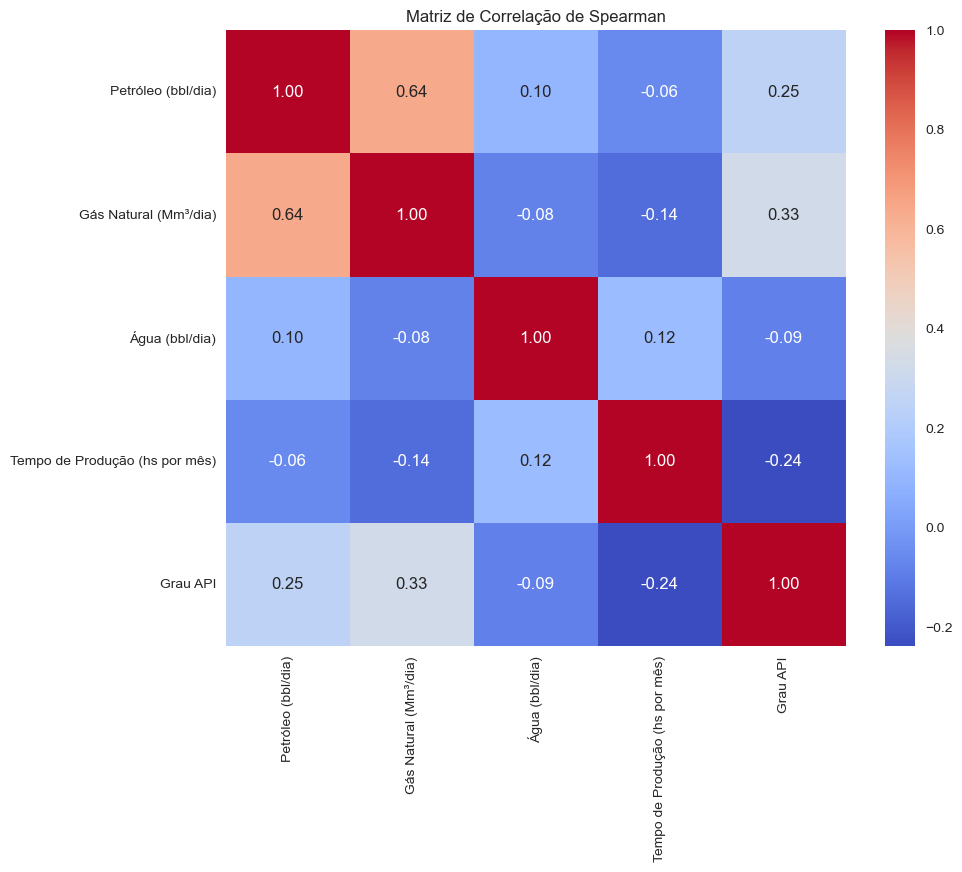

In [30]:
# Calculando a matriz de correlação de Spearman
correlation_matrix = df.corr(method='spearman', numeric_only=True)

# Plotando a matriz de correlação como um mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação de Spearman')
plt.show()

<a id='distribuicao-e-normalidade'></a>
### 4.3.3 Distribuição e Normalidade

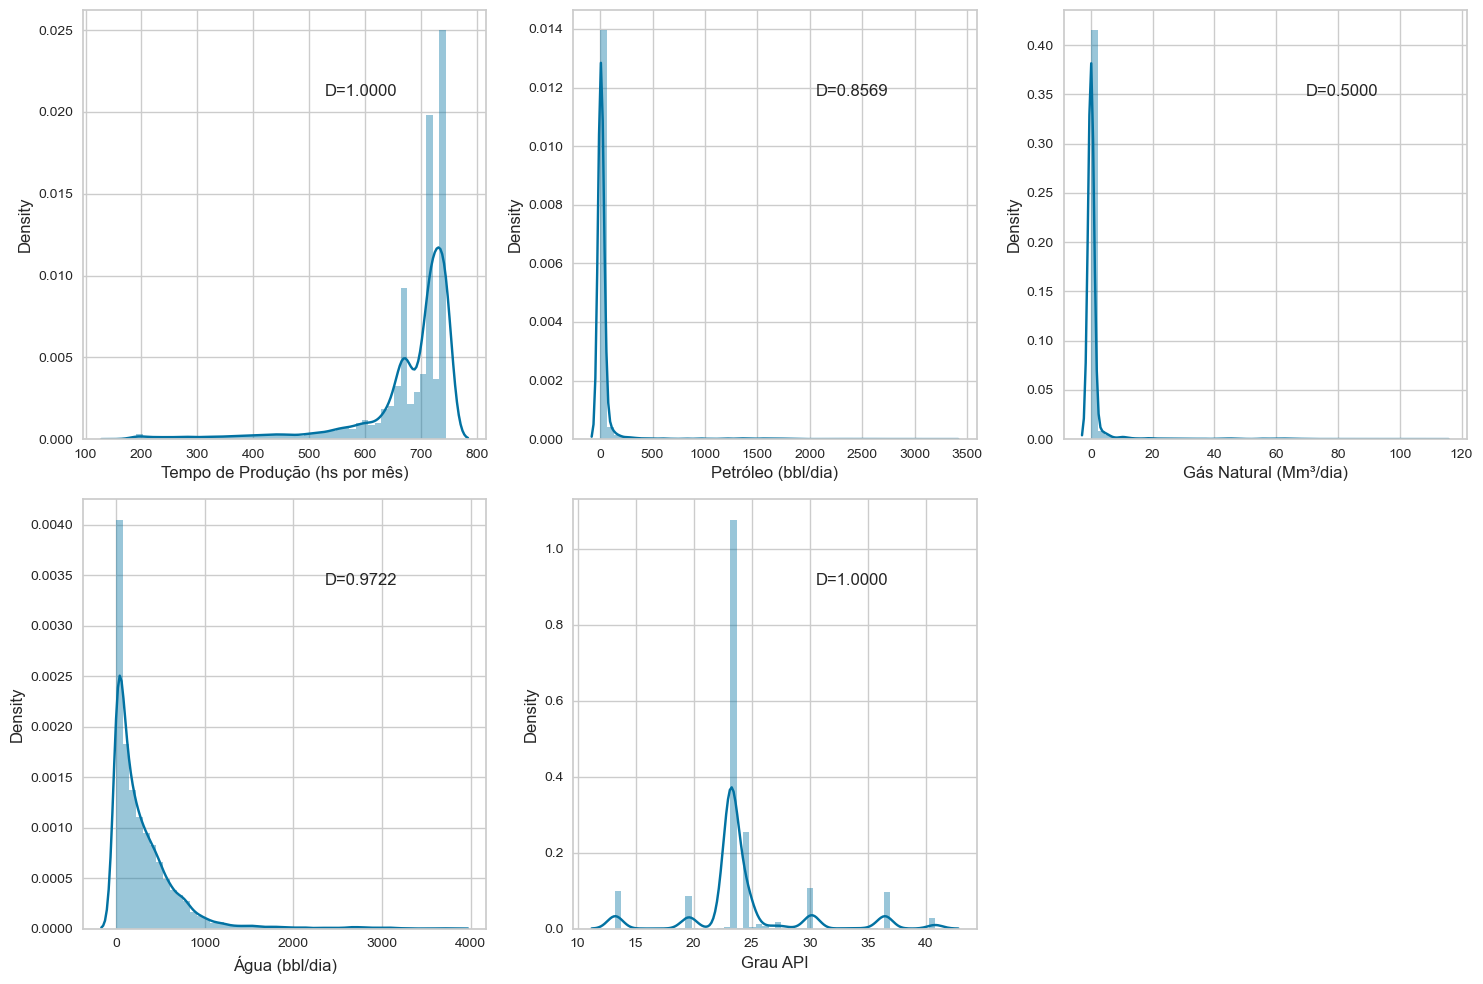

In [31]:
vars_conti = ['Tempo de Produção (hs por mês)', 'Petróleo (bbl/dia)', 'Gás Natural (Mm³/dia)',
              'Água (bbl/dia)', 'Grau API']

# Determinando o número de linhas e colunas para os subplots
n = len(vars_conti)
ncols = 3
nrows = n // ncols + (n % ncols > 0)

# Criando uma figura com subplots suficientes para todas as variáveis
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()  # para facilitar a iteração

# Loop através das variáveis
for i, var in enumerate(vars_conti):
    # para plotar
    data = df[var]
    
    # Criando um gráfico de distribuição para cada variável usando Seaborn
    sns.distplot(data, ax=axs[i])
    
    # Realizando o teste de Kolmogorov-Smirnov para a variável atual
    ks_test = stats.kstest(data, 'norm')
    
    # Adicionando o resultado do teste ao gráfico
    axs[i].annotate(f"D={ks_test.statistic:.4f}", xy=(0.6, 0.8), xycoords='axes fraction')

# Removendo os gráficos extras
for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

- Percebe-se uma variação muito grande na escala e na não normalidade dos dados, vamos apliicar transformações

<a id='bivariada-e-linearidade'></a>
### 4.3.4 Bivariada e Linearidade

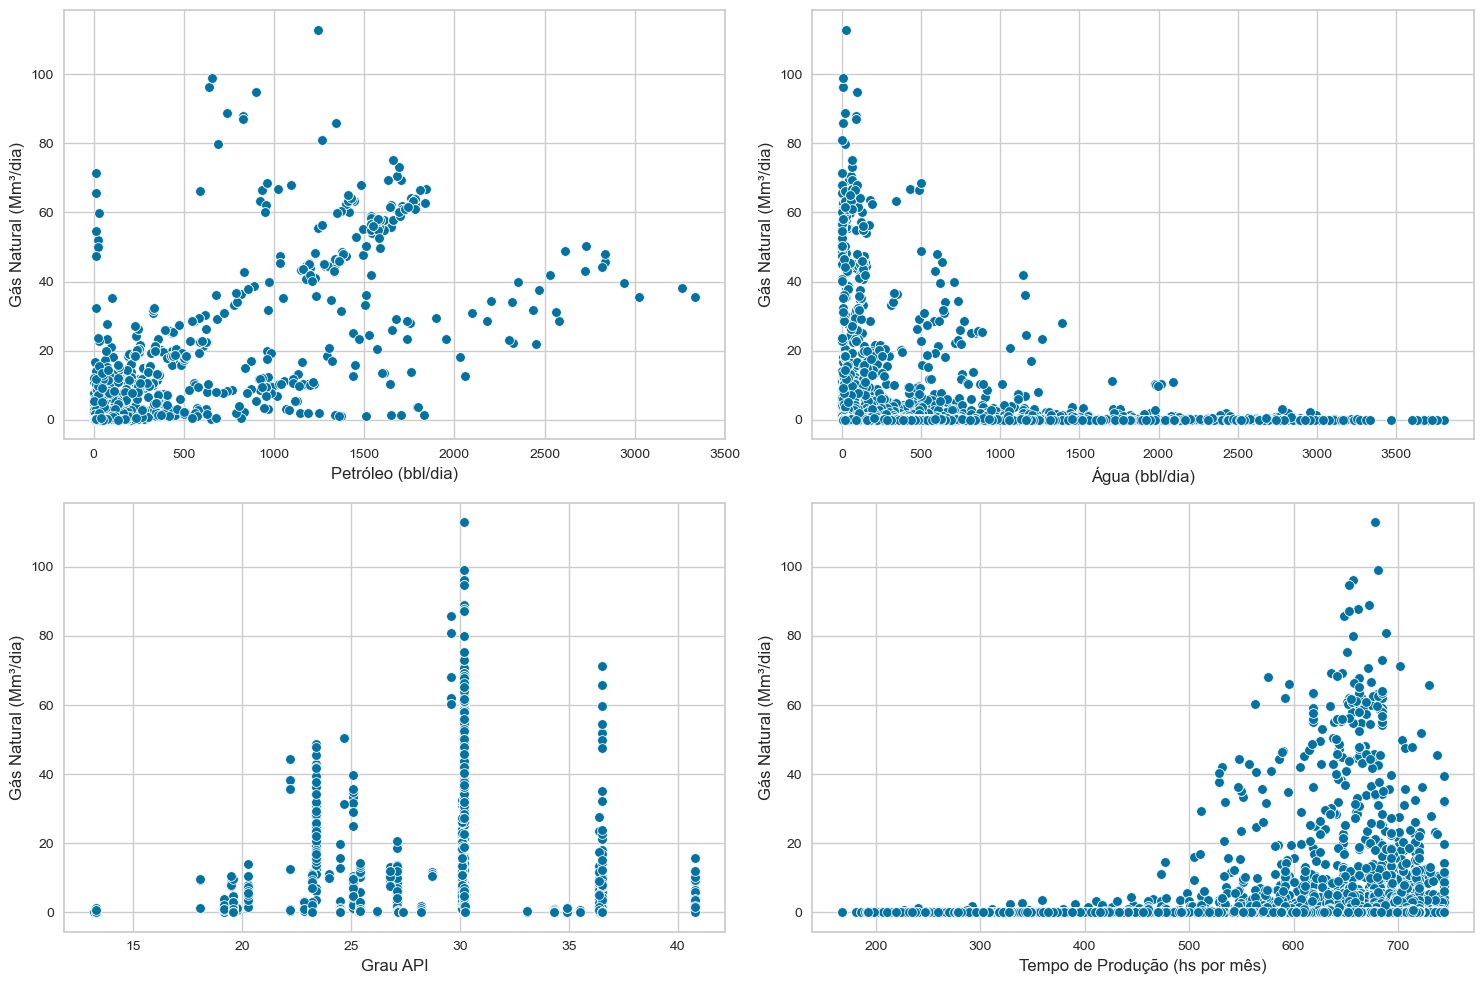

In [32]:
# Lista das variáveis explicativas
vars_cont = ['Petróleo (bbl/dia)','Água (bbl/dia)', 'Grau API', 'Tempo de Produção (hs por mês)']

# Criando uma figura com 4 subplots, 2 na primeira linha e 2 na segunda
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Achatando o array axs para facilitar a iteração
axs = axs.flatten()

# Loop através das variáveis
for i, var in enumerate(vars_cont):
    # Criando um gráfico de dispersão para cada variável usando Seaborn
    sns.scatterplot(data=df, x=var, y='Gás Natural (Mm³/dia)', ax=axs[i])

plt.tight_layout()
plt.show()

- Observamos uma linearidade maior no Petróleo, um viés a direita para a Água, uma sugestão de categorização do Grau API e um vié a esquerda para o Tempo de Produção. Vamos transformar as variáveis a fim de aumentar a linearização, corrigir escala e reduzir outliers.

<a id='transformacoes'></a>
### 4.3.5 Transformações

Como vimos a normalidade e linearidade é pouca entre as variáveiss continuas explicativas e a variável resposta, além das escalas serem diferentes. E por isso vamos aplicar transformações buscando a linearização e diminuição da diferença de escala das variáveis explicativas para a variável resposta 'Gás Natural (Mm³/dia)'.

A padronização seria uma opção, porém perderiamos interpretabilidade do modelo, e por isso vamos aplicar transformações matemáticas como o log e raiz quadrada.

In [33]:
# Lista de colunas para transformar
cols_to_transform = ['Petróleo (bbl/dia)', 'Água (bbl/dia)', 'Tempo de Produção (hs por mês)', 'Gás Natural (Mm³/dia)']

# Crie novas colunas com o sufixo '_log' para as transformações
for col in cols_to_transform:
    df[col + '_log'] = np.log(df[col])

In [34]:
# Crie uma nova coluna com o sufixo '_sqrt' para a transformação de raiz quadrada
df['Água (bbl/dia)_sqrt'] = np.sqrt(df['Água (bbl/dia)'])
df['Tempo de Produção (hs por mês)_sqrt'] = np.sqrt(df['Tempo de Produção (hs por mês)'])

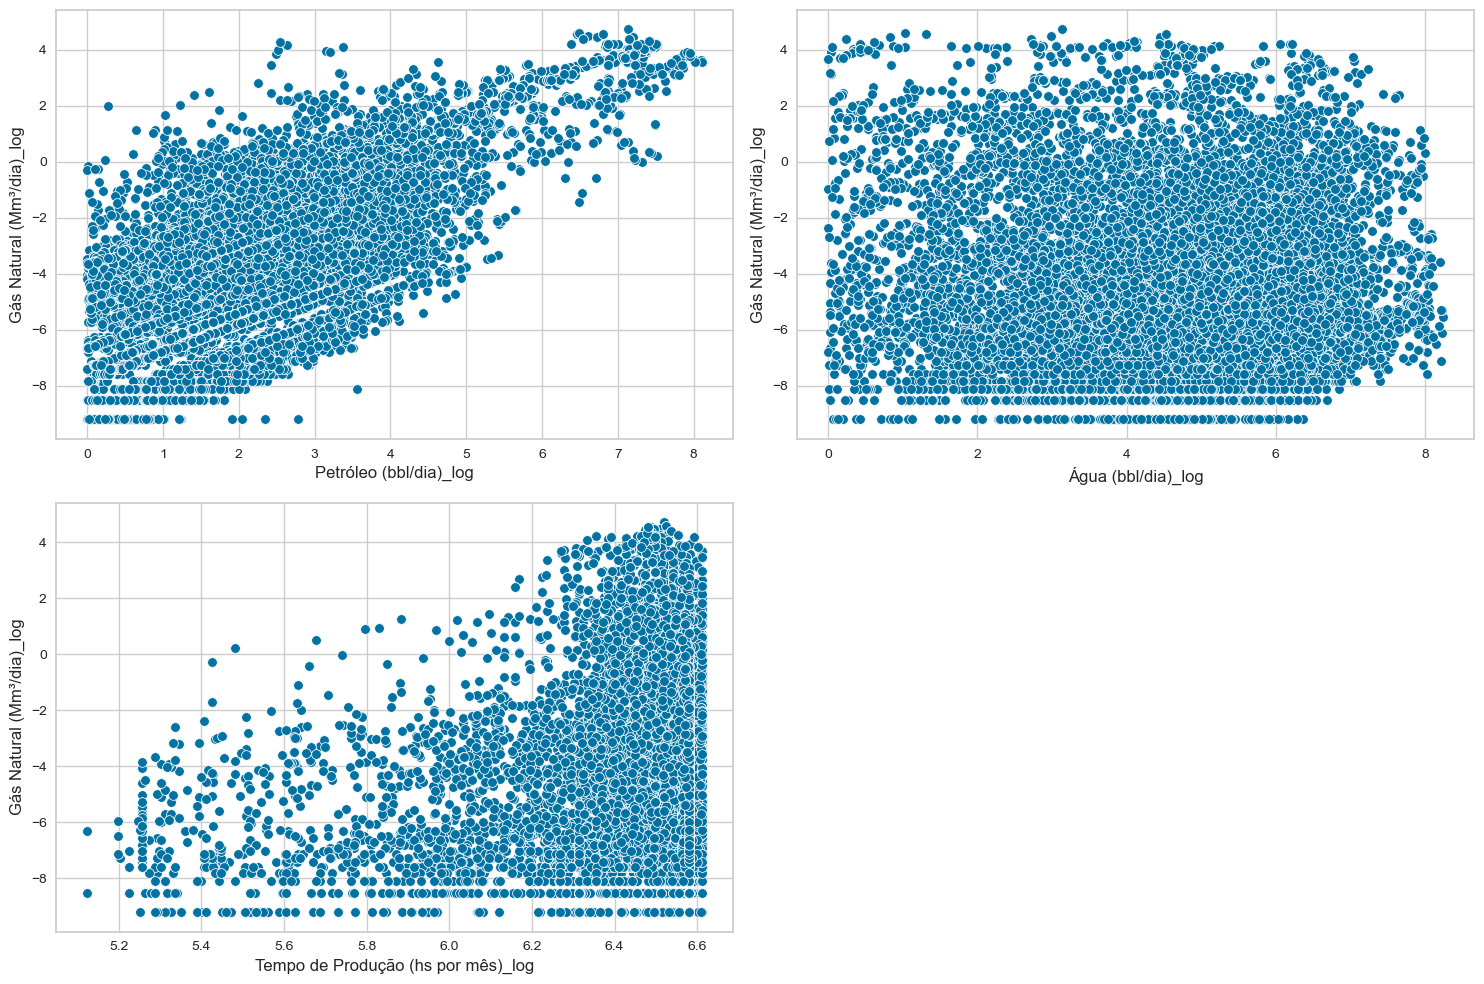

In [35]:
# Lista das variáveis explicativas
vars_cont_log = ['Petróleo (bbl/dia)_log','Água (bbl/dia)_log', 'Tempo de Produção (hs por mês)_log']

# Criando uma figura com 3 subplots, 1 na primeira linha e 2 na segunda
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Removendo o último subplot vazio
fig.delaxes(axs[1,1])

# Achatando o array axs para facilitar a iteração
axs = axs.flatten()[:-1]  # Excluindo o último elemento

# Loop através das variáveis
for i, var in enumerate(vars_cont_log):
    # Criando um gráfico de dispersão para cada variável usando Seaborn
    sns.scatterplot(data=df, x=var, y='Gás Natural (Mm³/dia)_log', ax=axs[i])

plt.tight_layout()
plt.show()

Percebe-se que uma transformação log - log onde tanto as variáveis explicativas quanto a resposta foram transformadas pelo logaritimo natural, reduziu os outliers aproximou as escalas e houve uma melhora importante na linearidade.

#### Categorizando 'Grau API'

Como vimos uma boa opção pode ser categorizar a variável 'Grau API', para avaliarmos seu uso no modelo

In [36]:
def categoriza_grau_api(grau_api):
    if grau_api > 45:
        return 'Leve_Particular'
    elif 33 <= grau_api <= 45:
        return 'Leve'
    elif 22 <= grau_api < 33:
        return 'Medio'
    elif 10 <= grau_api < 22:
        return 'Pesado'
    else:
        return 'Extra_Pesado'

df['Grau_API_Cat'] = df['Grau API'].apply(categoriza_grau_api)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20185 entries, 36 to 40033
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Estado                               20185 non-null  object 
 1   Bacia                                20185 non-null  object 
 2   Operador                             20185 non-null  object 
 3   Petróleo (bbl/dia)                   20185 non-null  float64
 4   Gás Natural (Mm³/dia)                20185 non-null  float64
 5   Água (bbl/dia)                       20185 non-null  float64
 6   Tempo de Produção (hs por mês)       20185 non-null  int64  
 7   Corrente                             20185 non-null  object 
 8   Grau API                             20185 non-null  float64
 9   Local                                20185 non-null  object 
 10  Estados_Bacias                       20185 non-null  object 
 11  Operador_Agrupado          

<a id='vif-fator-de-inflacao-da-variancia'></a>
### 4.3.6 VIF (Fator de Inflação da Variância)

Afim de evitar a multicolinearidade, vamos calcular o VIF para as principais variáveis contínuas

In [38]:
# Selecione apenas colunas do tipo int64 e float64
df_numerics = df[['Petróleo (bbl/dia)_log','Água (bbl/dia)_log', 'Tempo de Produção (hs por mês)_log',
                  'Grau API','Gás Natural (Mm³/dia)_log']]

# Adicione uma constante ao dataframe
df_numerics = add_constant(df_numerics)

# Calcule o VIF para cada variável
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_numerics.values, i) for i in range(df_numerics.shape[1])]
vars_vif["Feature"] = df_numerics.columns

vars_vif.round(2)

VIF Factor                             Feature
0     1216.01                               const
1        2.33              Petróleo (bbl/dia)_log
2        1.08                  Água (bbl/dia)_log
3        1.02  Tempo de Produção (hs por mês)_log
4        1.23                            Grau API
5        2.72           Gás Natural (Mm³/dia)_log

- Bons resultados de VIF, todos menores que 5

<a id='planejamento-do-modelo'></a>
# 5. Planejamento do modelo

Depois de analisar estatisticamente e fazer as transformações vamos testar algumas transformações e utilizar as variáveis que nos tragam interpretações para ser usado no mundo real.

<a id='comparando-modelos-com-o-pycaret'></a>
## 5.1 Comparando modelos com o Pycaret

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20185 entries, 36 to 40033
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Estado                               20185 non-null  object 
 1   Bacia                                20185 non-null  object 
 2   Operador                             20185 non-null  object 
 3   Petróleo (bbl/dia)                   20185 non-null  float64
 4   Gás Natural (Mm³/dia)                20185 non-null  float64
 5   Água (bbl/dia)                       20185 non-null  float64
 6   Tempo de Produção (hs por mês)       20185 non-null  int64  
 7   Corrente                             20185 non-null  object 
 8   Grau API                             20185 non-null  float64
 9   Local                                20185 non-null  object 
 10  Estados_Bacias                       20185 non-null  object 
 11  Operador_Agrupado          

In [40]:
# vars selecionadas
vars_selec = ['Estados_Bacias','Local','Operador_Agrupado','Grau_API_Cat',
'Gás Natural (Mm³/dia)_log','Petróleo (bbl/dia)_log','Água (bbl/dia)_log',
                'Tempo de Produção (hs por mês)_log']

In [41]:
df_encoded = pd.get_dummies(df[vars_selec], columns=df[vars_selec].select_dtypes(include=['object']).columns)

In [42]:
# Inicializa o setup
s = setup(df_encoded, target = 'Gás Natural (Mm³/dia)_log', session_id=123)

Pelo nosso problema de negócio, os algoritmos que vamos analisar precisam ser os regressores que quantificam o quanto as variáveis explicativas interferem na variável resposta

In [43]:
# Lista dos IDs dos modelos que quantifica o coeficiente das explicativas para a var resposta
modelos = ['lr', 'lasso', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard']

Quando transformamos a variável dependente (y) usando o logaritmo em uma regressão, estamos mudando a escala na qual a variável é medida. Isso tem implicações importantes para como interpretamos as métricas do modelo, como o coeficiente de determinação R².

O R² é uma medida de quão bem o modelo de regressão se ajusta aos dados. Em um modelo de regressão linear simples, o R² é calculado como:

\begin{equation}
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
\end{equation}

onde $SS_{res}$ é a soma dos quadrados dos resíduos (a diferença entre os valores observados e previstos) e $SS_{tot}$ é a soma total dos quadrados (a variabilidade total em torno da média).

Por isso para calcular o R² em escala original vamos adicionar novas métricas com a operação inversa (exponencial)

In [44]:
# Função para calcular o MAE na escala original
def mae_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

# Função para calcular o R² na escala original
def r2_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return r2_score(y_true, y_pred)

# Função para calcular o RMSLE na escala original
def rmsle_original_scale(y_true_log, y_pred_log):
    return np.sqrt(mean_squared_log_error(np.exp(y_true_log), np.exp(y_pred_log)))

# Função para calcular o MAPE na escala original
def mape_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred)

# Adiciona as métricas ao PyCaret
add_metric('mae_original_scale', 'MAE Original Scale', mae_original_scale, greater_is_better=False)
add_metric('r2_original_scale', 'R2 Original Scale', r2_original_scale, greater_is_better=True)
add_metric('rmsle_original_scale', 'RMSLE Original Scale', rmsle_original_scale, greater_is_better=False)
add_metric('mape_original_scale', 'MAPE Original Scale', mape_original_scale, greater_is_better=False)

Name                                               MAPE Original Scale
Display Name                                       MAPE Original Scale
Score Function       <function mape_original_scale at 0x0000016D858...
Scorer               make_scorer(mape_original_scale, greater_is_be...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: mape_original_scale, dtype: object

In [45]:
# Compare apenas os modelos especificados
best_model = compare_models(include=modelos, sort='R2 Original Scale')

Processing:   0%|          | 0/41 [00:00<?, ?it/s]

A regressão Ridge é uma variação da regressão linear que busca minimizar a soma dos resíduos quadrados somada a um termo de penalização. Este termo de penalização é dado por lambda multiplicado pela soma dos coeficientes ao quadrado.

Matematicamente, o objetivo da regressão Ridge é minimizar a seguinte função de custo:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n} \theta_j^2
$$

onde:
- $J(\theta)$ é a função de custo.
- $h_{\theta}(x^{(i)})$ é a hipótese do modelo no i-ésimo exemplo.
- $y^{(i)}$ é o valor real do i-ésimo exemplo.
- $\theta_j$ são os parâmetros do modelo.
- $\lambda$ é o parâmetro de regularização, que controla a força da penalização.
- $m$ é o número total de exemplos no conjunto de treinamento.
- $n$ é o número total de características (incluindo o viés).

A ideia por trás da regressão Ridge é introduzir um pouco de viés no modelo para reduzir a variância e evitar o overfitting. A escolha do valor de $\lambda$ determina o equilíbrio entre viés e variância. Um valor maior de $\lambda$ resultará em um maior viés (modelo mais simples), mas menor variância. Por outro lado, um valor menor de $\lambda$ resultará em menor viés (modelo mais complexo), mas maior variância.

<a id='avaliando-na-base-de-testes'></a>
### 5.1.1 Avaliando na base de testes

In [46]:
previsoes = predict_model(best_model)

In [47]:
# Obtendo o pipeline do modelo
pipeline = get_config('pipeline')
pipeline

Pipeline(memory=FastMemory(location=C:\Users\user\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Petróleo (bbl/dia)_log',
                                             'Água (bbl/dia)_log',
                                             'Tempo de Produção (hs por '
                                             'mês)_log',
                                             'Estados_Bacias_Alagoas_Alagoas',
                                             'Estados_Bacias_Bahia_RecÃ´ncavo',
                                             'Estados_Bacias_Ceará_Potiguar',
                                             'Estados_Bacias_Espírito '
                                             'Santo_Campos',...
                                             'Operador_Agrupado_Petro Rio O&G',
                                             'Operador_Agrupado_Prio Bravo',
                                             'Operador_Agrupado_Shell Brasil',
                                             'Grau_API_Cat_Leve',
                                             'Grau_API_Cat_Medio',
                                             'Grau_API_Cat_Pesado'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames()))])

<a id='regressao-no-stats-models'></a>
# 6. Regressão no Stats Models

O `summary` do `statsmodels` é uma ferramenta poderosa para avaliação estatística de um modelo. Ele fornece uma visão abrangente do desempenho do seu modelo.

Primeiramente, o resumo fornece medidas como **R-squared**, **AIC**, **BIC** que ajudam a entender o quão bem o modelo se ajusta aos dados. O **R-squared** é uma medida de quão bem as variáveis independentes explicam a variabilidade da variável dependente.

Além disso, o resumo fornece o valor-p para cada variável preditora. Um valor-p baixo (< 0.05) indica que a variável é significativa. Isso é crucial para entender quais variáveis têm um impacto significativo na variável dependente.

O resumo também fornece um intervalo de confiança de 95% para cada coeficiente. Isso ajuda a entender a incerteza associada à estimativa do coeficiente.

Por fim, o resumo lista os coeficientes de regressão para cada variável independente. Isso ajuda a entender a relação entre cada variável independente e a variável dependente. Portanto, o resumo do `statsmodels` é uma ferramenta essencial para entender o desempenho do seu modelo e a importância das variáveis preditoras.

<a id='summary'></a>
## 6.1 Summary

In [48]:
# Pegando a base transformada do setup do pycaret
X_train_transformado_stats = get_config('X_train_transformed')
X_test_transformado_stats = get_config('X_test_transformed')

y_train_transformado_stats = get_config('y_train_transformed')
y_test_transformado_stats = get_config('y_test_transformed')

In [49]:
# vars selecionadas
vars_stats = ['Estados_Bacias','Local','Operador_Agrupado','Grau_API_Cat',
'Gás Natural (Mm³/dia)_log','Petróleo (bbl/dia)_log','Água (bbl/dia)_log',
                'Tempo de Produção (hs por mês)_log']

# Cria variáveis dummy para as variáveis categóricas
df_dummies_stats = pd.get_dummies(df[vars_stats], columns=['Estados_Bacias', 'Operador_Agrupado',
                                                     'Local', 'Grau_API_Cat'])

In [50]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Definindo a variável resposta e as variáveis explicativas
y = df_dummies_stats['Gás Natural (Mm³/dia)_log']
X = df_dummies_stats.drop('Gás Natural (Mm³/dia)_log', axis=1)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


# Ajustando o modelo nos dados de treinamento sem a regularização
model = sm.OLS(y_train_transformado_stats, X_train_transformado_stats)
results = model.fit()

# Ajustando o modelo nos dados de treinamento e aplicando a penalização de ridge (L2)
model_ridge = sm.OLS(y_train_transformado_stats, X_train_transformado_stats)
results_ridge = model_ridge.fit_regularized(method='elastic_net', alpha=0.0001, L1_wt=0)

# Obtendo o resumo do modelo
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     Gás Natural (Mm³/dia)_log   R-squared (uncentered):                   0.921
Model:                                   OLS   Adj. R-squared (uncentered):              0.921
Method:                        Least Squares   F-statistic:                              7488.
Date:                       Mon, 06 Nov 2023   Prob (F-statistic):                        0.00
Time:                               11:05:27   Log-Likelihood:                         -25905.
No. Observations:                      14129   AIC:                                  5.185e+04
Df Residuals:                          14107   BIC:                                  5.202e+04
Df Model:                                 22                                                  
Covariance Type:                   nonrobust                                                  
===================================================================================================================================================================================================================================================================================================================================================================
                                                                                                                                                                                                                                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Petróleo (bbl/dia)_log                                                                                                                                                                                                                                                                              0.9323      0.014     66.947      0.000       0.905       0.960
Água (bbl/dia)_log                                                                                                                                                                                                                                                                                 -0.0458      0.009     -5.107      0.000      -0.063      -0.028
Tempo de Produção (hs por mês)_log                                                                                                                                                                                                                                                                  0.2036      0.070      2.893      0.004       0.066       0.342
Estados_Bacias_Alagoas_Alagoas                                                                                                                                                                                                                                                                      0.3074      0.234      1.314      0.189      -0.151       0.766
Estados_Bacias_Bahia_RecÃ´ncavo                                                                                                                                                                                                                                                                    -1.8754      0.246     -7.624      0.000      -2.358      -1.393
Estados_Bacias_Ceará_Potiguar                              

- Se o coeficiente é 0.84 em um modelo de regressão log-log, isso significa que uma mudança de 1% na variável explicativa está associada a uma mudança de 0.84% na variável resposta, mantendo todas as outras variáveis constantes.Portanto, se a variável explicativa aumentar em 10%, a variável resposta aumentará em 0.91∗10=8.4%,em média, mantendo todas as outras variáveis constantes.Espero que isso ajude! Se você tiver mais perguntas, sinta-se à vontade para perguntar.

<a id='avaliacao-do-modelo-e-residuos'></a>
## 6.2 Avaliação do modelo e resíduos

In [51]:
from sklearn.metrics import r2_score

# Fazendo previsões nos dados de teste
log_y_pred = results.predict(X_train_transformado_stats)

# Retransformando as previsões e os valores reais para a escala original
y_pred = np.exp(log_y_pred)
y_train_exp = np.exp(y_train_transformado_stats)

# Calculando o R² na escala original
r2 = r2_score(y_train_exp, y_pred)
print('R² na escala original:', r2)

R² na escala original: 0.848682061291546


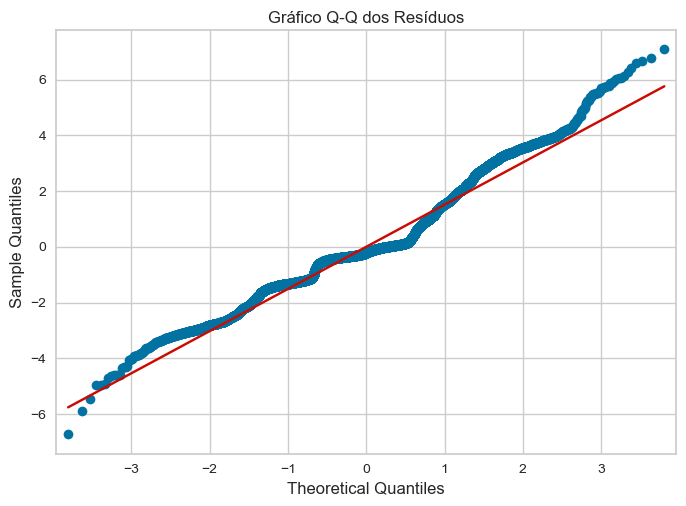

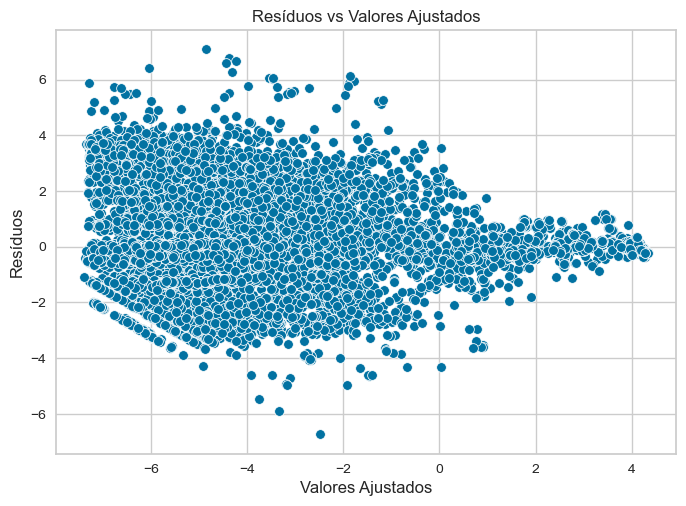

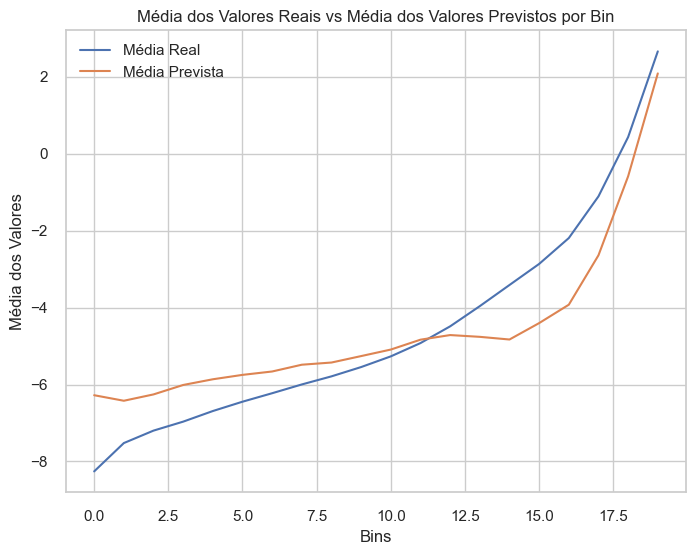

In [52]:
# Calculando os resíduos
residuos = y_train_transformado_stats - results.predict(X_train_transformado_stats)

# Obtendo os valores previstos na base de treino
y_previsto = results.predict(X_train_transformado_stats)

# Plotando um gráfico Q-Q dos resíduos
sm.qqplot(residuos, line='s')
plt.title('Gráfico Q-Q dos Resíduos')
plt.show()

# Plotando os resíduos contra os valores ajustados
valores_ajustados = results_ridge.fittedvalues
sns.scatterplot(x=valores_ajustados, y=residuos)
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.show()

# Criando os bins com qcut
bins = pd.qcut(y_train_transformado_stats, q=20)

# Calculando as médias dentro dos bins para os valores reais e previstos
media_real = y_train_transformado_stats.groupby(bins).mean()
media_previsto = y_previsto.groupby(bins).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

# Plotando a linha para os valores reais
sns.lineplot(x=range(len(media_real)), y=media_real, label='Média Real')

# Plotando a linha para os valores previstos
sns.lineplot(x=range(len(media_previsto)), y=media_previsto, label='Média Prevista')

plt.xlabel('Bins')
plt.ylabel('Média dos Valores')
plt.title('Média dos Valores Reais vs Média dos Valores Previstos por Bin')
plt.legend()

plt.show()

- Outras opções de linearização, como a Regressão Lowess ou a Regressão Segmentada perderiamos muito em interpretabilidade quantificada dos coeficientes em relação a variável resposta.

<a id='regressao-scikitlearn'></a>
# 7. Regressão ScikitLearn

O `Scikit-learn` é uma biblioteca de aprendizado de máquina em Python que se destaca por sua **eficiência**, **praticidade** e **versatilidade**.

Em termos de **eficiência**, o `Scikit-learn` é construído para desempenho. Ele contém muitas ferramentas eficientes para aprendizado de máquina e modelagem estatística, tornando-o uma escolha popular para tarefas de aprendizado de máquina.

Quanto à **praticidade**, o `Scikit-learn` foi projetado para ser simples e fácil de usar. Ele oferece uma API consistente e fácil de usar, o que facilita a implementação de modelos de aprendizado de máquina.

Finalmente, em termos de **versatilidade**, o `Scikit-learn` suporta uma ampla variedade de algoritmos de aprendizado supervisionado e não supervisionado. Ele também inclui várias ferramentas de pré-processamento para normalização, escala e codificação de dados.

Portanto, o `Scikit-learn` é uma ferramenta essencial para qualquer cientista de dados ou profissional de aprendizado de máquina. Ele combina eficiência, praticidade e versatilidade em uma única biblioteca.

In [53]:
from sklearn.linear_model import Ridge

# Crie o modelo Ridge
modelo_ridge = Ridge(alpha=1, random_state = 123 )

# Treine o modelo com seus dados
modelo_ridge.fit(X_train_transformado_stats, y_train_transformado_stats)

Ridge(alpha=1, random_state=123)

In [54]:
# Agora o modelo está treinado e você pode fazer previsões (na escala logarítmica)
y_predito_log = modelo_ridge.predict(X_train_transformado_stats)

# Retransformar para a escala original
y = np.exp(y_train_transformado_stats)
y_predito = np.exp(y_predito_log)

# Calcule o MSE e o R² na escala original
mse = mean_squared_error(y, y_predito)
r2 = r2_score(y, y_predito)

print(f'MSE: {mse}')
print(f'R²: {r2}')

MSE: 6.968036651611328
R²: 0.8486218185517467


In [55]:
# Use o modelo treinado para fazer previsões nos dados de teste (na escala logarítmica)
y_test_predito_log = modelo_ridge.predict(X_test_transformado_stats)

# Retransformar para a escala original
y_test = np.exp(y_test_transformado_stats)
y_test_predito = np.exp(y_test_predito_log)

# Calcule o MSE e o R² na escala original para os dados de teste
mse_teste = mean_squared_error(y_test, y_test_predito)
r2_teste = r2_score(y_test, y_test_predito)

print(f'MSE de teste: {mse_teste}')
print(f'R² de teste: {r2_teste}')

MSE de teste: 7.291121482849121
R² de teste: 0.8621694424931367


<a id='modelo-final'></a>
# 8. Modelo Final

<a id='setup'></a>
## 8.1 Setup

In [56]:
# vars selecionadas
vars_encoded = ['Estados_Bacias','Local','Operador_Agrupado','Grau_API_Cat',
'Gás Natural (Mm³/dia)_log','Petróleo (bbl/dia)_log','Água (bbl/dia)_log',
                'Tempo de Produção (hs por mês)_log']

df_encoded_final = pd.get_dummies(df[vars_encoded], columns=df[vars_encoded].select_dtypes(include=['object']).columns)

In [57]:
# Inicializa o setup
setup_final = setup(df_encoded_final, target = 'Gás Natural (Mm³/dia)_log')

<a id='validacao-cruzada-do-modelo'></a>
## 8.2 Validação Cruzada do modelo

A função `create_model` do `pycaret` cria o modelo e ainda oferece os resultados da validação cruzada na base de treino

In [58]:
# Função para calcular o MAE na escala original
def mae_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

# Função para calcular o MSE na escala original
def mse_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_squared_error(y_true, y_pred)

# Função para calcular o RMSE na escala original
def rmse_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return sqrt(mean_squared_error(y_true, y_pred))

# Função para calcular o R² na escala original
def r2_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return r2_score(y_true, y_pred)

# Função para calcular o RMSLE na escala original
def rmsle_original_scale(y_true_log, y_pred_log):
    return np.sqrt(mean_squared_log_error(np.exp(y_true_log), np.exp(y_pred_log)))

# Função para calcular o MAPE na escala original
def mape_original_scale(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred)
# Adiciona as métricas ao PyCaret
add_metric('mae_original_scale', 'MAE Original Scale', mae_original_scale, greater_is_better=False)
add_metric('r2_original_scale', 'R2 Original Scale', r2_original_scale, greater_is_better=True)
add_metric('mse_original_scale', 'MSE Original Scale', mse_original_scale, greater_is_better=False)
add_metric('rmse_original_scale', 'RMSE Original Scale', rmse_original_scale, greater_is_better=False)
add_metric('rmsle_original_scale', 'RMSLE Original Scale', rmsle_original_scale, greater_is_better=False)
add_metric('mape_original_scale', 'MAPE Original Scale', mape_original_scale, greater_is_better=False)

Name                                               MAPE Original Scale
Display Name                                       MAPE Original Scale
Score Function       <function mape_original_scale at 0x0000016D85C...
Scorer               make_scorer(mape_original_scale, greater_is_be...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: mape_original_scale, dtype: object

In [59]:
# Criação do modelo de regressão linear
reg_final = create_model('ridge')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

- Vemos bons resultados na base de treino, com um MAE original baixo, o MSE original um pouco alto, o que é esperado, já que uma transformação log, penaliza os erros quadráticos, já que o mínimo de erro ger auma grande diferença. Mas em geral um resultando interessante e útil.

<a id='validacao-cruzada-do-modelo'></a>
## 8.3 Avaliação do modelo

Avaliar gráficamente os resíduos e na base de testes

In [60]:
# Base transformada do setup
X_train_transformado = get_config('X_train_transformed')
X_test_transformado = get_config('X_test_transformed')

y_train_transformado = get_config('y_train_transformed')
y_test_transformado = get_config('y_test_transformed')

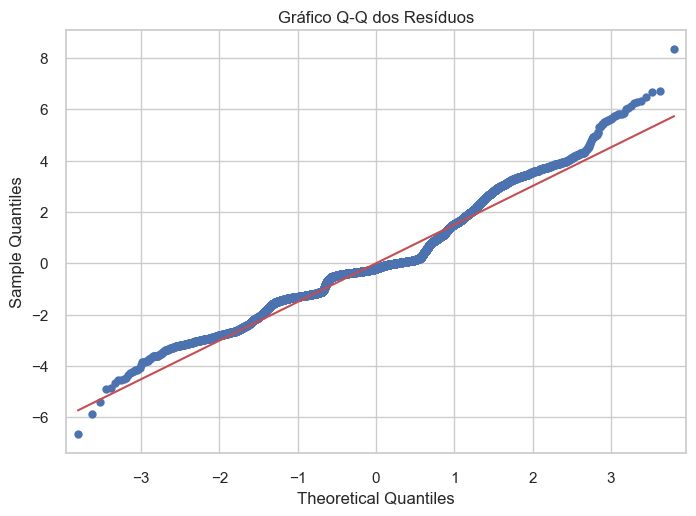

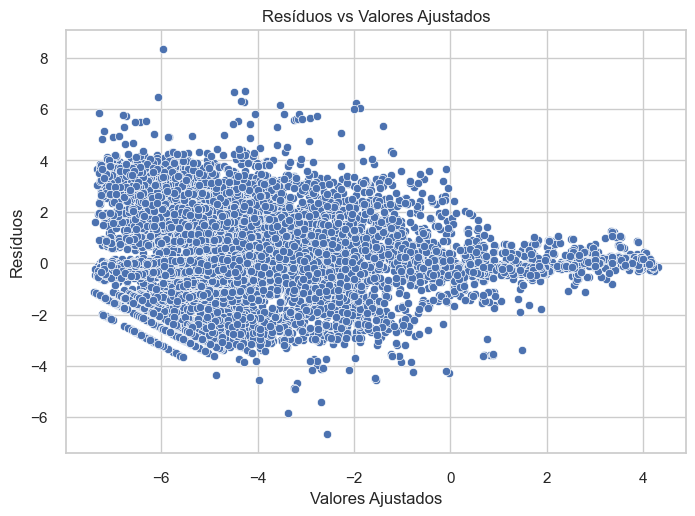

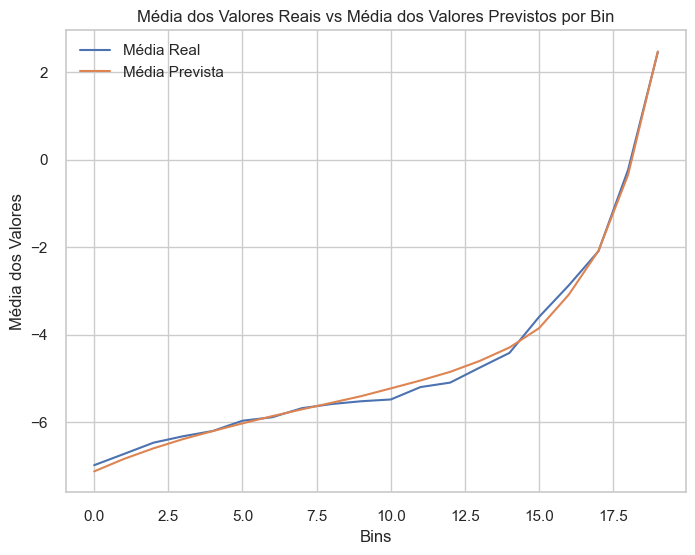

In [61]:
# Obtendo os valores previstos na base de treino
y_previsto = reg_final.predict(X_train_transformado)

# Calculando os resíduos
residuos = y_train_transformado - y_previsto

# Plotando um gráfico Q-Q dos resíduos
sm.qqplot(residuos, line='s')
plt.title('Gráfico Q-Q dos Resíduos')
plt.show()

# Plotando os resíduos contra os valores ajustados
valores_ajustados = y_previsto
sns.scatterplot(x=valores_ajustados, y=residuos)
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.show()

# Criando DataFrames para os valores verdadeiros e previstos
df_train = pd.DataFrame({
    'Verdadeiro': y_train_transformado,
    'Previsto': y_previsto
})

# Criando os bins com qcut
bins = pd.qcut(df_train['Previsto'], q=20)

# Calculando as médias dentro dos bins para os valores reais e previstos
media_verdadeiro = df_train['Verdadeiro'].groupby(bins).mean()
media_previsto = df_train['Previsto'].groupby(bins).mean()

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

# Plotando a linha para as médias dos valores reais
sns.lineplot(x=range(len(media_verdadeiro)), y=media_verdadeiro, label='Média Real')

# Plotando a linha para as médias dos valores previstos
sns.lineplot(x=range(len(media_previsto)), y=media_previsto, label='Média Prevista')

plt.xlabel('Bins')
plt.ylabel('Média dos Valores')
plt.title('Média dos Valores Reais vs Média dos Valores Previstos por Bin')
plt.legend()

plt.show()

<a id='data-frames-com-as-previsoes'></a>
## 8.4 Data Frames com as previsões 

<a id='treino'></a>
### 8.4.1 Treino

In [62]:
# Pegando a base de treino
X_train2 = get_config('X_train_transformed')

y_train2 = get_config('y_train_transformed')

In [63]:
previsao_train = predict_model(reg_final, data=X_train2)

In [64]:
# Aplicando a função exponencial para reverter a transformação logarítmica
previsao_train['prediction_label_original'] = np.exp(previsao_train['prediction_label'])

# Revertendo a transformação logarítmica
previsao_train['prediction_label_original'] = np.exp(previsao_train['prediction_label'])* 1e6
previsao_train['y_true_original'] = np.exp(y_train2)* 1e6

# escala do modelo mesmo
previsao_train['prediction_label'] = previsao_train['prediction_label']
previsao_train['y_true'] = y_train2

y_true = previsao_train['y_true']
y_pred = previsao_train['prediction_label']

<a id='teste'></a>
### 8.4.2 Teste

In [65]:
# Avaliando na base de testes
previsao_test = predict_model(reg_final)

<a id='salvando-o-modelo-e-pipeline'></a>
## 8.5 Salvando o modelo e pipeline

In [66]:
# Salvando o modelo
save_model(reg_final, 'reg_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\user\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Petróleo (bbl/dia)_log',
                                              'Água (bbl/dia)_log',
                                              'Tempo de Produção (hs por '
                                              'mês)_log',
                                              'Estados_Bacias_Alagoas_Alagoas',
                                              'Estados_Bacias_Bahia_RecÃ´ncavo',
                                              'Estados_Bacias_Ceará_Potiguar',
                                              'Estados_Bacias_Espírito '
                                              'Santo_Campos',...
                                              'Operador_Agrupado_Shell Brasil',
                                              'Grau_API_Cat_Leve',
                                              'Grau_API_Cat_Medio',
                

<a id='relatorio-gerencial'></a>
# 9. Relatório Gerencial

Analisar o quanto cada variável interfere matematicamente na variável resposta, lembrando que a variável resposta foi transformada por log, mudando a interpretação dos coeficientes.

<a id='interferencia-das-variaveis-explicativas-na-producao-de-gas'></a>
## 9.1 Interferência das variáveis explicativas na produção de gás

In [67]:
# Pegar os coeficientes do modelo
def interpret_coefficients(model, X_train):
    coef = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
    return coef

In [68]:
# Pegando os coeficientes do modelo e criando um data frame com eles
X_train_transformado2 = get_config('X_train_transformed')
coef_df = pd.DataFrame(reg_final.coef_, X_train_transformado2.columns, columns=['Coefficient'])

In [69]:
def plot_continuous(coef_df, variable):
    # Calcule a mudança na variável de resposta para um aumento de 10% na variável explicativa
    changes = [(np.exp(coef_df.loc[variable, 'Coefficient'] * increase / 100) - 1) * 100 for increase in np.arange(0, 110, 10)]
    
    # Crie o gráfico
    fig = go.Figure(data=go.Scatter(x=np.arange(0, 110, 10), y=changes))
    fig.update_layout(title='Impacto de um aumento em ' + variable + ' na variável de resposta',
                      xaxis_title='Aumento na ' + variable + ' (%)',
                      yaxis_title='Mudança na variável de resposta (%)',
                      xaxis=dict(tickmode='linear', tick0=0, dtick=10),
                      yaxis=dict(tickmode='linear', tick0=0, dtick=10))
    fig.show()

def plot_categorical(coef_df, variable_prefix):
    # Filtrar as colunas que pertencem à mesma variável categórica
    categories = [col for col in coef_df.index if col.startswith(variable_prefix)]
    
    # Calcule a mudança na variável de resposta para cada categoria
    changes = [np.exp(coef_df.loc[category, 'Coefficient']) - 1 for category in categories]
    
    # Encontre a parte comum no início das categorias
    common_prefix = os.path.commonprefix(categories)
    
    # Crie o gráfico
    fig = go.Figure()
    for category, change in zip(categories, changes):
        fig.add_trace(go.Bar(x=[category.replace(common_prefix, '')[:25]], 
                             y=[change], 
                             marker_color='rgb('+str(np.random.randint(0,255))+','+str(np.random.randint(0,255))+','+str(np.random.randint(0,255))+')',
                             showlegend=False))
        
    fig.update_layout(
        title='Impacto das categorias de ' + variable_prefix + ' na variável de resposta',
        xaxis_title='Categoria',
        yaxis_title='Mudança na média de produção de Gás por categoria (%)',
        autosize=True,
        width=1000,  # Largura do gráfico
        height=800)  # Altura do gráfico
    fig.show()

<a id='continuas'></a>
### 9.1.1 Contínuas

In [70]:
# Para uma variável contínua (por exemplo, 'variavel_continua')
plot_continuous(coef_df, 'Petróleo (bbl/dia)_log')

Em uma regressão **log-log**, os coeficientes representam **elasticidades**. Isso significa que eles medem a variação percentual na variável dependente resultante de uma variação percentual de 1% na variável independente.

Matematicamente, isso pode ser expresso como:

\begin{equation}
\frac{\partial Y}{Y} = \beta \frac{\partial X}{X}
\end{equation}

onde:
- $Y$ é a variável dependente,
- $X$ é a variável independente,
- $\beta$ é o coeficiente da variável independente.

Portanto, um coeficiente $\beta$ de 0.96 significa que um aumento de 1% em $X$ resultará, em média, em um aumento de 0.96% em $Y$.

Por exemplo, se estamos considerando a produção de gás ($Y$) e a variável petróleo ($X$), e o coeficiente para a variável petróleo é 0.96, isso significa que **para aumentar a produção de gás em 10%, precisamos aumentar a variável petróleo em 9.6% (0.96 * 10), mantendo todas as outras variáveis constantes.**

<a id='dummies'></a>
### 9.1.2 Dummies

In [72]:
# Para uma variável categórica (por exemplo, 'variavel_categorica')
plot_categorical(coef_df, 'Corrente')

Para variáveis **categóricas** em uma regressão **log-log**, a interpretação é um pouco diferente.

As variáveis categóricas são frequentemente incluídas em modelos de regressão como **variáveis dummy**. Uma variável dummy é uma variável binária que indica a presença (1) ou ausência (0) de alguma categoria.

Em uma regressão log-log, um coeficiente para uma variável dummy representa a variação percentual na variável dependente quando a categoria está presente, em comparação com quando está ausente.

Matematicamente, isso pode ser expresso como:

\begin{equation}
\frac{\partial Y}{Y} = \beta D
\end{equation}

onde:
- $Y$ é a variável dependente,
- $D$ é a variável dummy (1 se a categoria está presente, 0 se ausente),
- $\beta$ é o coeficiente da variável dummy.

Portanto, um coeficiente $\beta$ de -0.33 para a categoria 'Perenco Brasil' da variável dummy 'Operador_Agrupado' significa que, quando a operadora é 'Perenco Brasil', a produção de gás é, em média, 33% menor do que quando a operadora é a categoria de referência, mantendo todas as outras variáveis constantes.

Da mesma forma, um coeficiente $\beta$ de 0.74 para a categoria 'Shell Brasil' significa que, quando a operadora é 'Shell Brasil', a produção de gás é, em média, 74% maior do que quando a operadora é a categoria de referência, mantendo todas as outras variáveis constantes.

Portanto, se mantivermos todas as outras variáveis constantes e trocarmos a operadora de 'Perenco Brasil' para 'Shell Brasil', esperamos que a produção de gás aumente em aproximadamente **107% (74% - (-33%)), na escala original.**